# Flexible representation of quantum images - [FRQI](https://link.springer.com/content/pdf/10.1007/s11128-010-0177-y.pdf)

## Representation equation $| I(\theta)\rangle = \frac{1}{2^n}\sum_{i=0}^{2^{2n}-1}(cos\theta_i | 0 \rangle + sin\theta_i | 1 \rangle) \otimes | i \rangle$, where

$\theta_i$ - continuous representation of the inensity,

$i$ - binary expansion of the pixel coordinate.

Step 0: dependencies import

In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math
from ibm_washington_config import coupling_map, basis_gates
from ionq_config import coupling_map, basis_gates

Step 1: image generation

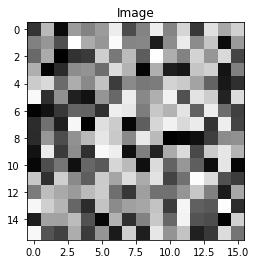

In [2]:
image = np.random.uniform(low=0, high=255, size=(16,16)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

Step 2: flattening image into vector (for convenience). Calculation of sufficient nuber of qubits.

In [3]:
input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

Step 3: quantum circuit building.

In [4]:
O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    # for coord_or_intns in (0,1):
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    # qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

Metrics

| Image size  | Depth measure | # of utilized qubits |Washington depth | IonQ depth |
| ------------- | ------------- | -------------------|-----------------|------------|
| 2  | 20  | 3 | 211| 98|
| 4  | 467  | 5 | 2776| 962|
| 8  | 8003  | 7 | 49404| 16130|
| 16  | 130307  | 9 | |260351|
| 32  | 2094083  | 11|
| 64  | -  | 13 |
| 128  | -  | 15 |
| 256  | -  | 17 |

In [5]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 130307, # of qubits is 9


In [21]:
wash_qc = transpile(circuits=qc_image, coupling_map=coupling_map, basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))
# wash_qc.draw()

depth is 260351


Circuit drawing

Step 4: quantum circuit execution, measurments' interpretation

In [6]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=20000)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)

[47, 165, 18, 156, 133, 159, 231, 81, 111, 238, 132, 205, 52, 230, 158, 209, 142, 148, 69, 256, 157, 153, 256, 128, 139, 20, 140, 237, 138, 194, 19, 166, 101, 176, 0, 39, 62, 210, 126, 189, 81, 256, 168, 121, 208, 148, 203, 66, 171, 0, 51, 159, 143, 101, 205, 182, 0, 172, 0, 0, 194, 205, 0, 111, 207, 214, 119, 154, 138, 203, 51, 149, 109, 98, 201, 212, 177, 88, 25, 48, 256, 64, 148, 32, 26, 154, 114, 229, 125, 165, 256, 78, 238, 209, 36, 214, 0, 18, 58, 125, 106, 63, 238, 231, 118, 197, 170, 220, 125, 230, 96, 76, 41, 108, 36, 256, 0, 237, 197, 0, 92, 222, 239, 222, 239, 49, 228, 82, 54, 145, 71, 150, 169, 229, 206, 132, 238, 173, 0, 0, 18, 52, 142, 143, 26, 237, 64, 147, 34, 256, 256, 19, 131, 34, 178, 212, 51, 208, 228, 181, 18, 98, 119, 0, 96, 89, 207, 183, 0, 212, 90, 130, 87, 0, 238, 0, 207, 55, 212, 134, 117, 191, 144, 212, 169, 230, 63, 107, 256, 219, 92, 46, 116, 193, 178, 158, 202, 204, 101, 59, 168, 123, 110, 147, 187, 137, 19, 167, 256, 218, 185, 114, 60, 200, 141, 155, 175,

Input and measured images comparison

In [7]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

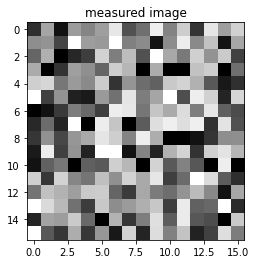

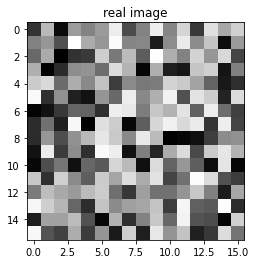

In [8]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)